In [1]:
import sys
sys.path.append('../../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs.visuals import vis
from libs.visuals import gridfan
from libs.visuals import gridcons
from libs.metrics import aggregators

Available LLMs: (24): llama-3.1-8b llama-4-scout llama-4-mav gpt-oss-20b gpt-oss-120b qwen3-8b qwen3-14b qwen3-32b qwen3-30b-a3b-2507 qwen3-235b-a22b-2507 gemma-3-12b gemma-3-27b mistral-small-3.2-24b mistral-medium-3 llama-3.1-70b llama-3.3-70b llama-3.1-405b grok-4-fast deepseek-chat-v3.1 deepseek-r1-0528 gemini-2.5-flash gemini-2.5-flash-grounded gemini-2.5-pro gemini-2.5-pro-grounded


/home/espinl/.conda/envs/py311_llmscholar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

In [3]:
BENCHMARKS_PATH = '../../results/interventions/benchmarks/'

PLOTS_PATH = '../../results/interventions/plots'
TABLES_PATH = '../../results/interventions/tables'
LATEX_PATH = '../../results/interventions/latex'

io.validate_path(PLOTS_PATH)
io.validate_path(TABLES_PATH)
io.validate_path(LATEX_PATH)

## Data

In [4]:
PREFIX = 'biased_prompt'
ATTRIBUTE = 'gender'       # 'gender', 'ethnicity', 'citations', 'diverse'
DIVERSITY_PANELS_ONLY = False  # True, False

In [5]:

TASK_PARAMS_BY_ATTRIBUTE = {
    'gender': constants.TASK_TOPK_BIASED_PARAMS_GENDER,
    'ethnicity': constants.TASK_TOPK_BIASED_PARAMS_ETHNICITY,
    'citations': constants.TASK_TOPK_BIASED_PARAMS_CITATIONS,
    'diverse': constants.TASK_TOPK_BIASED_PARAMS_DIVERSE,
}
HUE_LABEL_MAP = {
    'gender': {
        "top_100_bias_gender_equal": "Equal",
        "top_100_bias_gender_female": "Only Female",
        "top_100_bias_gender_male": "Only Male",
        "top_100_bias_gender_neutral": "Only Neutral",
    },
    'ethnicity': {
        "top_100_bias_ethnicity_equal": "Equal",
        "top_100_bias_ethnicity_asian": "Only Asian",
        "top_100_bias_ethnicity_black": "Only Black",
        "top_100_bias_ethnicity_latino": "Only Latino",
        'top_100_bias_ethnicity_white': 'Only White',
    },
    'citations': {
        "top_100_bias_citations_high": "Highly cited (> 1000 citations)",
        "top_100_bias_citations_low": "Lowly cited (< 1000 citations)",
    },
    'diverse': {
        'top_100_bias_diverse': 'Diverse',
    }
}
HUE_COLOR_MAP = {
    'gender': gridcons.BIASED_PROMPT_GENDER_COLORS,
    'ethnicity': gridcons.BIASED_PROMPT_ETHNICITY_COLORS,
    'citations': gridcons.BIASED_PROMPT_CITATIONS_COLORS,
    'diverse': gridcons.BIASED_PROMPT_DIVERSE_COLORS,
}
HUE_ORDER = {
    'gender': ['top_100_bias_gender_equal', 'top_100_bias_gender_female', 'top_100_bias_gender_male', 'top_100_bias_gender_neutral'],
    'ethnicity': ['top_100_bias_ethnicity_equal', 'top_100_bias_ethnicity_asian', 'top_100_bias_ethnicity_white', 'top_100_bias_ethnicity_latino', 'top_100_bias_ethnicity_black'],
    'citations': ['top_100_bias_citations_low', 'top_100_bias_citations_high'],
    'diverse': ['top_100_bias_diverse'],
}


In [6]:
files = io.get_files(BENCHMARKS_PATH, f'per_attempt_*.csv')
df_per_attempt_all = io.pd.concat([io.read_csv(fn, index_col=0, low_memory=False) for fn in files], ignore_index=True)
df_per_attempt_all.shape

(582560, 15)

In [7]:
# filtering out rag and non-biased prompts
query_bias = constants.EXPERIMENT_TYPE_QUERY_TO_FILTER_RECORDS['constrained_prompting']
df_per_attempt_biased = df_per_attempt_all.query(query_bias).copy()

# query baseline
query_baseline = constants.EXPERIMENT_TYPE_QUERY_TO_FILTER_RECORDS['baseline_top_100']
df_per_attempt_baseline = df_per_attempt_all.query(query_baseline).copy()


df_per_attempt_biased.shape, df_per_attempt_baseline.shape

((224043, 15), (19774, 15))

# Plots

In [8]:
vis.sns_reset()
vis.sns_paper_style(font_scale=constants.FONT_SCALE)

## Across all models

In [9]:
# GROUP DATA
df_summary_bias_group = io.pd.DataFrame()
df_summary_baseline_group = io.pd.DataFrame()

alpha_ci = 0.05
metric_name_col = 'metric_name'
metric_value_col = 'metric_value'
cols_order = ['task_param', 'n','metric_name','mean','std','median','sum','ci','ci_low','ci_high']

groupby = ['metric_name', 'task_param']

# biased
per_group_biased = aggregators.aggregate_per_group(df_per_attempt_biased, groupby, alpha=alpha_ci, metric_value_col=metric_value_col, metric_name_col=metric_name_col)
per_group_biased = per_group_biased[cols_order]
df_summary_bias_group = io.pd.concat([df_summary_bias_group, per_group_biased], axis=0, ignore_index=True)

# baseline
per_group_baseline = aggregators.aggregate_per_group(df_per_attempt_baseline, groupby, alpha=alpha_ci, metric_value_col=metric_value_col, metric_name_col=metric_name_col)
per_group_baseline = per_group_baseline[cols_order]
df_summary_baseline_group = io.pd.concat([df_summary_baseline_group, per_group_baseline], axis=0, ignore_index=True)



# SELECT DATA (TYPE OF BIAS)
df_summary_bias_gender = df_summary_bias_group.query("task_param in @TASK_PARAMS_BY_ATTRIBUTE[@ATTRIBUTE]").copy()



# PIVOT DATA
index = ['task_param']

values = df_summary_baseline_group.pivot(index=index, columns='metric_name', values='mean')
ci_low = df_summary_baseline_group.pivot(index=index, columns='metric_name', values='ci_low')
ci_high = df_summary_baseline_group.pivot(index=index, columns='metric_name', values='ci_high')
before = {'values':values, 'ci_low':ci_low, 'ci_high':ci_high}

values = df_summary_bias_gender.pivot(index=index, columns='metric_name', values='mean')
ci_low = df_summary_bias_gender.pivot(index=index, columns='metric_name', values='ci_low')
ci_high = df_summary_bias_gender.pivot(index=index, columns='metric_name', values='ci_high')
after = {'values':values, 'ci_low':ci_low, 'ci_high':ci_high}


df_summary_bias_group.shape, df_summary_baseline_group.shape, df_summary_bias_gender.shape

((216, 10), (18, 10), (72, 10))

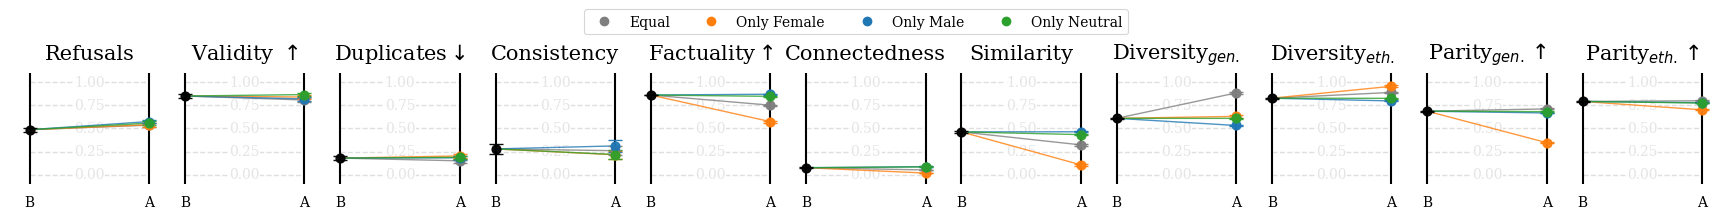

In [10]:
panels = gridcons.PANELS_METRICS_BEFORE_AFTER_FULLER if not DIVERSITY_PANELS_ONLY else gridcons.PANELS_METRICS_BEFORE_AFTER_DIVERSITY

connector_kwargs = dict(
    linewidth=1.,
    linestyle="-",
    alpha=0.8,
)

errorbar_kwargs = dict(
    capsize=5,
    elinewidth=0.5,
)

index_order=None 

index_label_maps=None

width_ratios = gridfan.grid.width_ratios_for_split(k_panels=len(panels), bars_share=0.999) 

fig = gridfan.plot_metric_grid_fan_from_pivot(
    before=before,
    after=after,
    panels=panels,
    hue_label_map=HUE_LABEL_MAP[ATTRIBUTE],
    hue_color_map=HUE_COLOR_MAP[ATTRIBUTE],
    hue_order=HUE_ORDER[ATTRIBUTE],
    layout=gridfan.LayoutSpec(figsize=(18, 1.5), width_ratios=width_ratios, separator_lw=0, wspace=0.0),
    style=gridfan.StyleSpec(title_fontsize=gridcons.TITLE_FONT_SIZE, 
                             tick_fontsize=gridcons.BEFORE_AFTER_TICK_FONT_SIZE, tick_font_color=gridcons.TICK_FONT_COLOR,
                             draw_x_vlines=True,
                                x_vlines_color="black",
                                x_vlines_lw=1.5,
                                x_vlines_alpha=1.0,
                             hide_spines_bottom=True,
                             keep_bottom_spine=False,
                             tick_pad=0.08,
                             title_pad=10,
                            ),
    index_order=index_order,
    index_label_maps=index_label_maps,
    connector_kwargs=connector_kwargs,
    before_errorbar_kwargs=errorbar_kwargs,
    after_errorbar_kwargs=errorbar_kwargs,
    legend_kwargs=dict(
        bbox_to_anchor=(0.51, 1.35),
    ),
    single_index_as_ylabel=False,
    x_labels=gridcons.BEFORE_AFTER_X_LABELS,
)

postfix = '_social' if DIVERSITY_PANELS_ONLY else ''
fn = io.path_join(PLOTS_PATH, f"{PREFIX}_{ATTRIBUTE}_all{postfix}.pdf")
if fn is not None:
    fig.savefig(fn, bbox_inches="tight", dpi=constants.FIG_DPI)

vis.plt.show()
vis.plt.close()


## By group model

In [11]:
# GROUP DATA
df_summary_bias_group = io.pd.DataFrame()
df_summary_baseline_group = io.pd.DataFrame()

alpha_ci = 0.05
metric_name_col = 'metric_name'
metric_value_col = 'metric_value'
cols_order = ['model_group','model_kind', 'task_param', 'n','metric_name','mean','std','median','sum','ci','ci_low','ci_high']

for group in constants.BENCHMARK_MODEL_GROUPS:
    groupby = [group, 'metric_name', 'task_param']

    # biased
    per_grou_biased = aggregators.aggregate_per_group(df_per_attempt_biased, groupby, alpha=alpha_ci, metric_value_col=metric_value_col, metric_name_col=metric_name_col)
    per_grou_biased.rename(columns={group: 'model_kind'}, inplace=True)
    per_grou_biased.loc[:, 'model_group'] = group
    per_grou_biased = per_grou_biased[cols_order]
    df_summary_bias_group = io.pd.concat([df_summary_bias_group, per_grou_biased], axis=0, ignore_index=True)

    # baseline
    per_group_baseline = aggregators.aggregate_per_group(df_per_attempt_baseline, groupby, alpha=alpha_ci, metric_value_col=metric_value_col, metric_name_col=metric_name_col)
    per_group_baseline.rename(columns={group: 'model_kind'}, inplace=True)
    per_group_baseline.loc[:, 'model_group'] = group
    per_group_baseline = per_group_baseline[cols_order]
    df_summary_baseline_group = io.pd.concat([df_summary_baseline_group, per_group_baseline], axis=0, ignore_index=True)



# SELECT DATA (TYPE OF BIAS)
df_summary_bias_gender = df_summary_bias_group.query("task_param in @TASK_PARAMS_BY_ATTRIBUTE[@ATTRIBUTE]").copy()



# PIVOT DATA
index = ['model_group','model_kind', 'task_param']

values = df_summary_baseline_group.pivot(index=index, columns='metric_name', values='mean')
ci_low = df_summary_baseline_group.pivot(index=index, columns='metric_name', values='ci_low')
ci_high = df_summary_baseline_group.pivot(index=index, columns='metric_name', values='ci_high')
before = {'values':values, 'ci_low':ci_low, 'ci_high':ci_high}

values = df_summary_bias_gender.pivot(index=index, columns='metric_name', values='mean')
ci_low = df_summary_bias_gender.pivot(index=index, columns='metric_name', values='ci_low')
ci_high = df_summary_bias_gender.pivot(index=index, columns='metric_name', values='ci_high')
after = {'values':values, 'ci_low':ci_low, 'ci_high':ci_high}


df_summary_bias_group.shape, df_summary_baseline_group.shape, df_summary_bias_gender.shape

((1728, 12), (144, 12), (576, 12))

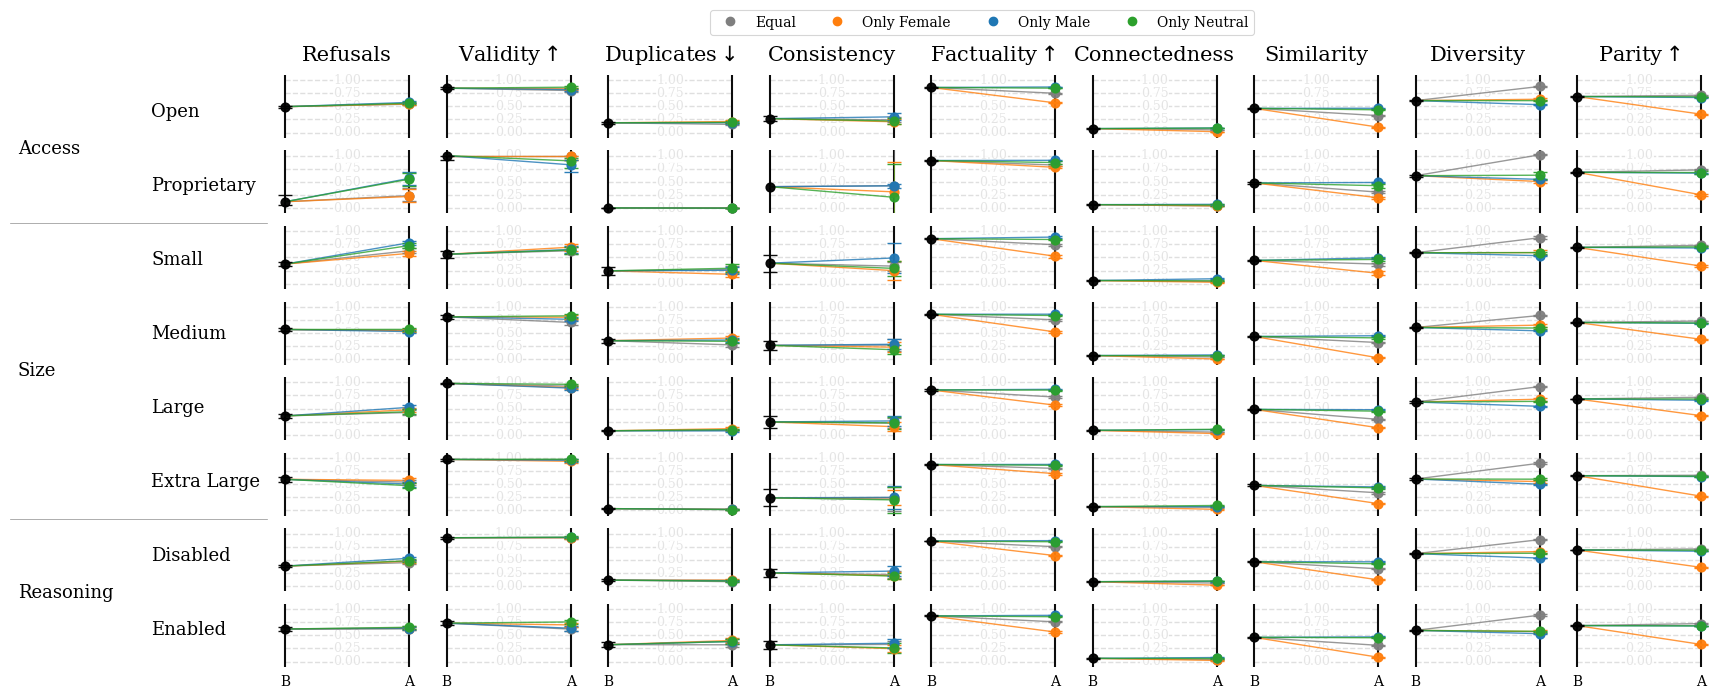

In [12]:

panels = gridcons.PANELS_METRICS_BEFORE_AFTER

connector_kwargs = dict(
    linewidth=1.,
    linestyle="-",
    alpha=0.8,
)

errorbar_kwargs = dict(
    capsize=5,
    elinewidth=0.5,
)

index_order=[(group, subg) for group in constants.BENCHMARK_MODEL_GROUPS for subg in constants.BENCHMARK_MODEL_GROUP_ORDER_WITHIN_GROUP[group]]

index_label_maps={
    0: constants.BENCHMARK_MODEL_GROUPS_LABEL_MAP,
    1: constants.BENCHMARK_MODEL_GROUP_LABEL_MAP,
}

width_ratios = gridfan.grid.width_ratios_for_split(k_panels=len(panels), bars_share=0.85) 

fig = gridfan.plot_metric_grid_fan_from_pivot(
    before=before,
    after=after,
    panels=panels,
    hue_label_map=HUE_LABEL_MAP[ATTRIBUTE],
    hue_color_map=HUE_COLOR_MAP[ATTRIBUTE],
    hue_order=HUE_ORDER[ATTRIBUTE],
    layout=gridfan.LayoutSpec(figsize=(18, 8), wspace=0., hspace=0.2, separator_lw=0.5, width_ratios=width_ratios),
    style=gridfan.StyleSpec(title_fontsize=gridcons.TITLE_FONT_SIZE, 
                             label_fontsize=gridcons.YLABEL_FONT_SIZE,
                             tick_fontsize=gridcons.BEFORE_AFTER_TICK_FONT_SIZE, tick_font_color=gridcons.TICK_FONT_COLOR,
                             value_fontsize=10,
                            internal_y_label_fontsize=9,
                            annotate_points=False, ylabel_pad=0.1, keep_bottom_spine=False, x_vlines_lw=1.5, x_vlines_color="black",
                            tick_pad=0.05,
                            title_pad=10),
    index_order=index_order,
    index_label_maps=index_label_maps,
    connector_kwargs=connector_kwargs,
    before_errorbar_kwargs=errorbar_kwargs,
    after_errorbar_kwargs=errorbar_kwargs,
    legend_kwargs=dict(
        bbox_to_anchor=(0.58, 0.97),
    ),
    x_labels=gridcons.BEFORE_AFTER_X_LABELS,
)


postfix = '_social' if DIVERSITY_PANELS_ONLY else ''
fn = io.path_join(PLOTS_PATH, f"{PREFIX}_{ATTRIBUTE}_by_model_group{postfix}.pdf")
if fn is not None:
    fig.savefig(fn, bbox_inches="tight", dpi=constants.FIG_DPI)

vis.plt.show()
vis.plt.close()


## By model

In [13]:
# GROUP DATA
df_summary_bias_group = io.pd.DataFrame()
df_summary_baseline_group = io.pd.DataFrame()

alpha_ci = 0.05
metric_name_col = 'metric_name'
metric_value_col = 'metric_value'


groupby = ['model', 'metric_name', 'task_param']

# biased
per_grou_biased = aggregators.aggregate_per_group(df_per_attempt_biased, groupby, alpha=alpha_ci, metric_value_col=metric_value_col, metric_name_col=metric_name_col)
cols_order = ['model', 'task_param', 'n','metric_name','mean','std','median','sum','ci','ci_low','ci_high']
per_grou_biased = per_grou_biased[cols_order]
df_summary_bias_group = io.pd.concat([df_summary_bias_group, per_grou_biased], axis=0, ignore_index=True)

# baseline
per_group_baseline = aggregators.aggregate_per_group(df_per_attempt_baseline, groupby, alpha=alpha_ci, metric_value_col=metric_value_col, metric_name_col=metric_name_col)
per_group_baseline = per_group_baseline[cols_order]
df_summary_baseline_group = io.pd.concat([df_summary_baseline_group, per_group_baseline], axis=0, ignore_index=True)



# SELECT DATA (TYPE OF BIAS)
df_summary_bias_gender = df_summary_bias_group.query("task_param in @TASK_PARAMS_BY_ATTRIBUTE[@ATTRIBUTE]").copy()



# PIVOT DATA
index = ['model','task_param']

values = df_summary_baseline_group.pivot(index=index, columns='metric_name', values='mean')
ci_low = df_summary_baseline_group.pivot(index=index, columns='metric_name', values='ci_low')
ci_high = df_summary_baseline_group.pivot(index=index, columns='metric_name', values='ci_high')
before = {'values':values, 'ci_low':ci_low, 'ci_high':ci_high}

values = df_summary_bias_gender.pivot(index=index, columns='metric_name', values='mean')
ci_low = df_summary_bias_gender.pivot(index=index, columns='metric_name', values='ci_low')
ci_high = df_summary_bias_gender.pivot(index=index, columns='metric_name', values='ci_high')
after = {'values':values, 'ci_low':ci_low, 'ci_high':ci_high}


df_summary_bias_group.shape, df_summary_baseline_group.shape, df_summary_bias_gender.shape

((4524, 11), (396, 11), (1584, 11))

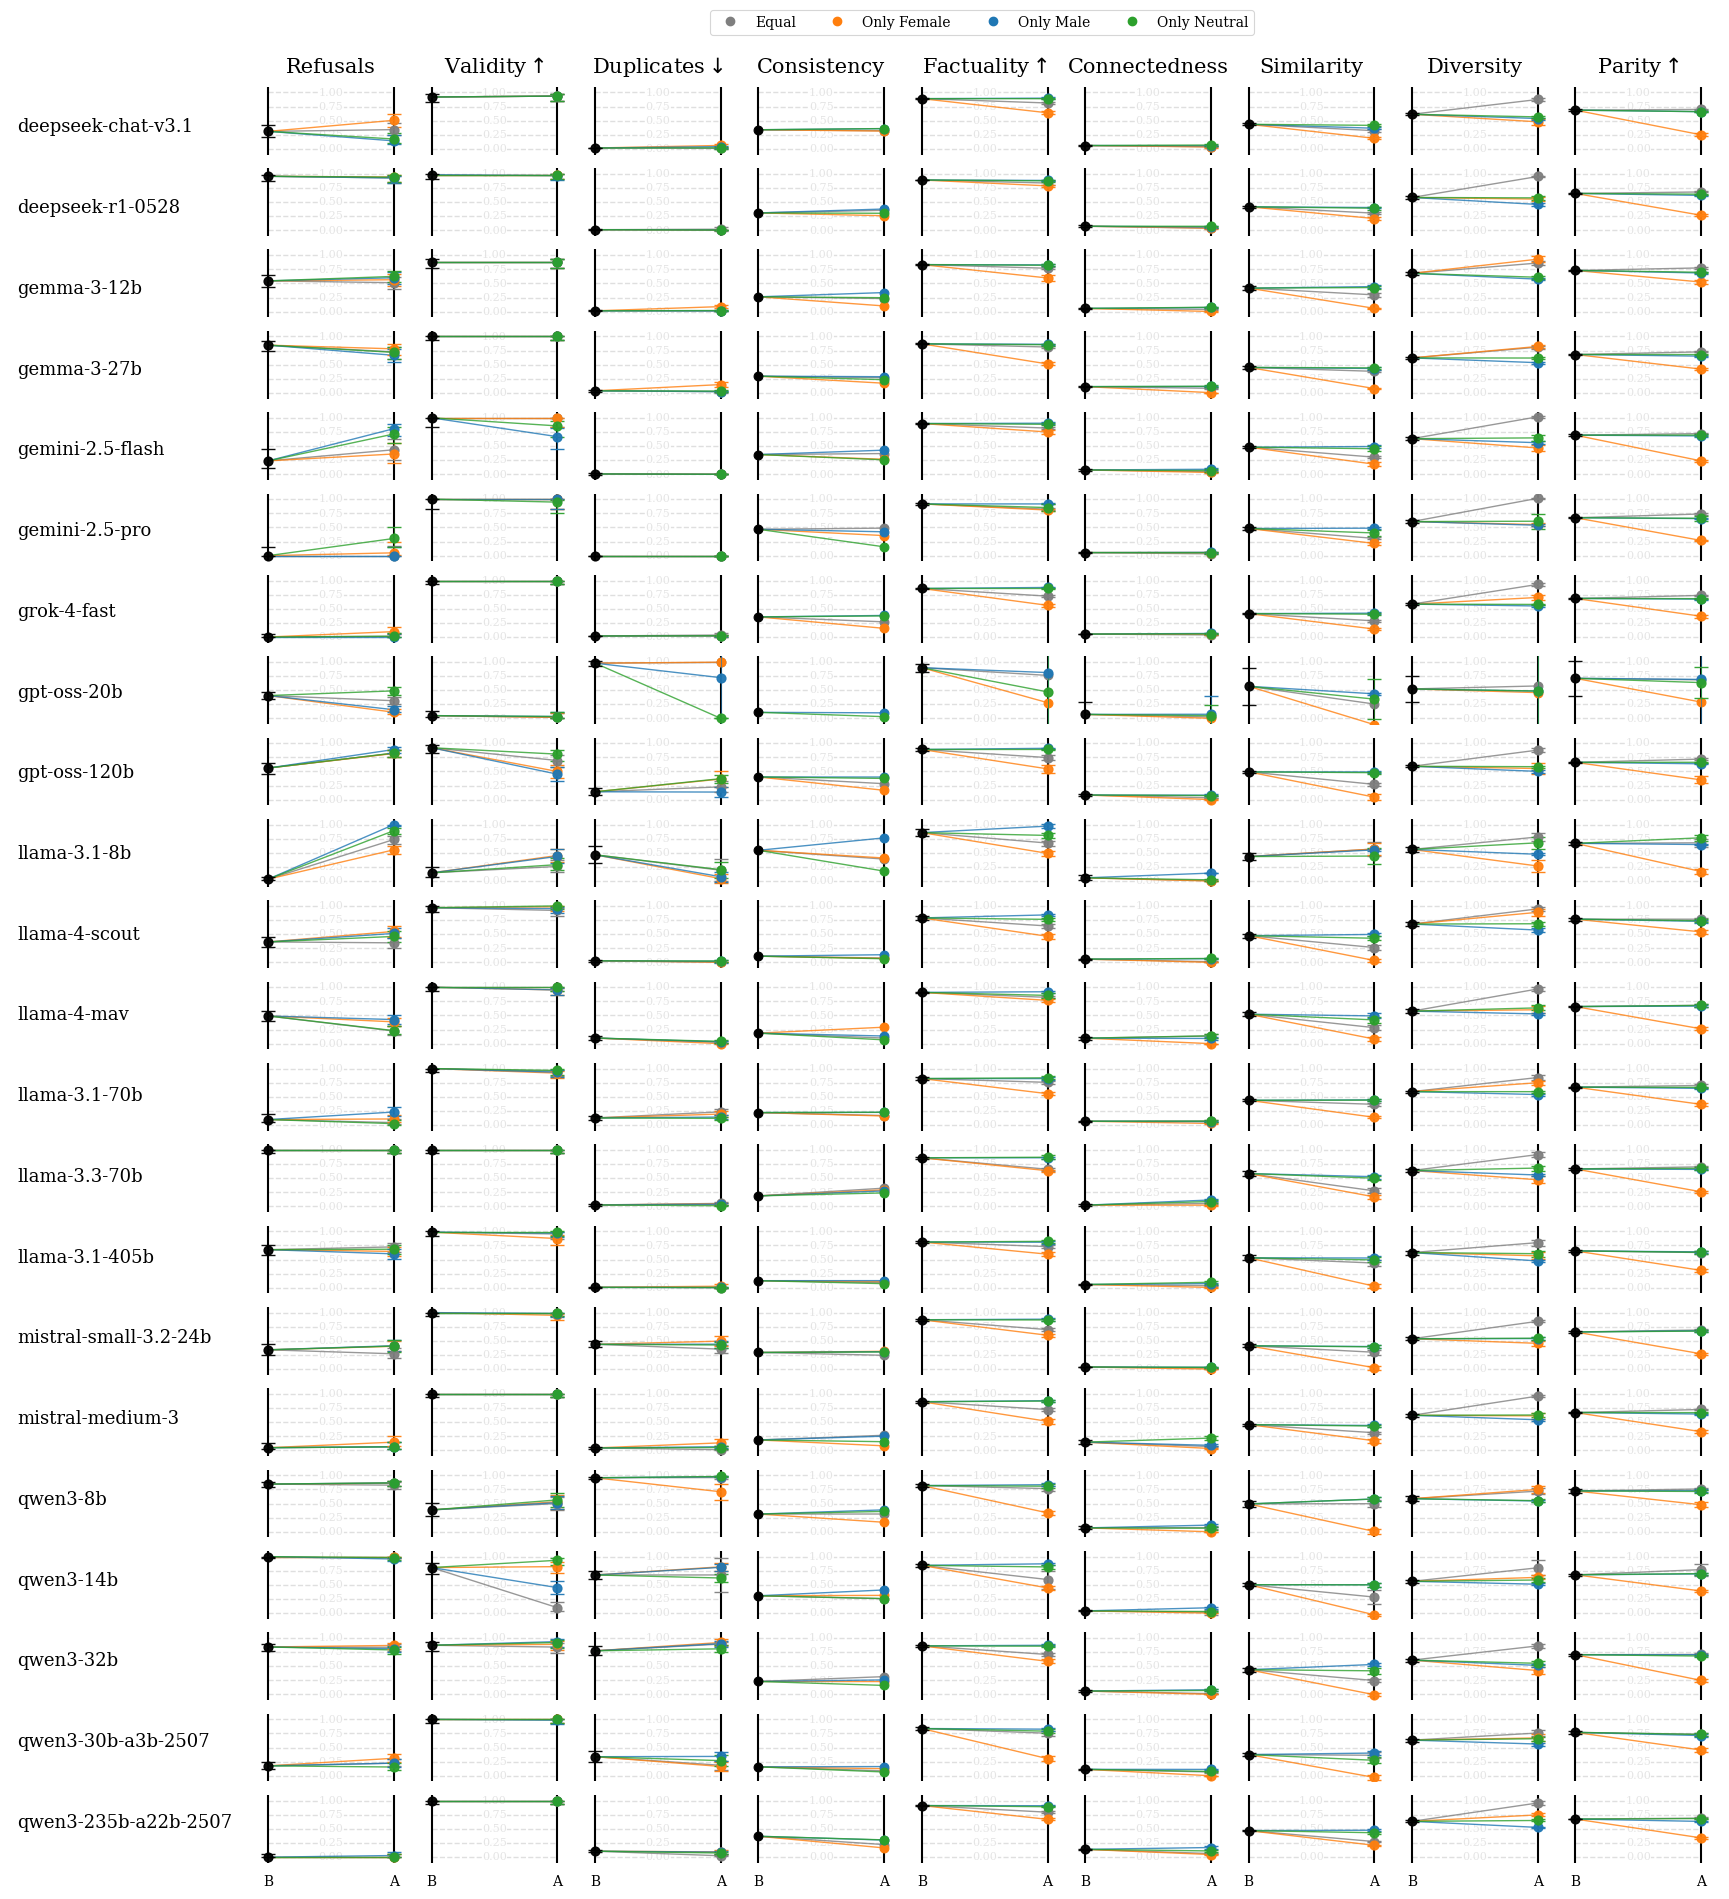

In [14]:
panels = gridcons.PANELS_METRICS_BEFORE_AFTER

connector_kwargs = dict(
    linewidth=1.,
    linestyle="-",
    alpha=0.8,
)

errorbar_kwargs = dict(
    capsize=5,
    elinewidth=0.5,
)

index_order=[llm for llm in constants.LLMS_ORDERED if 'grounded' not in llm]

index_label_maps=None

width_ratios = gridfan.grid.width_ratios_for_split(k_panels=len(panels), bars_share=0.86) 

fig = gridfan.plot_metric_grid_fan_from_pivot(
    before=before,
    after=after,
    panels=panels,
    hue_label_map=HUE_LABEL_MAP[ATTRIBUTE],
    hue_color_map=HUE_COLOR_MAP[ATTRIBUTE],
    hue_order=HUE_ORDER[ATTRIBUTE],
    layout=gridfan.LayoutSpec(figsize=(18, 24), width_ratios=width_ratios, separator_lw=0, wspace=0., hspace=0.2),
    style=gridfan.StyleSpec(title_fontsize=gridcons.TITLE_FONT_SIZE, 
                             label_fontsize=gridcons.YLABEL_FONT_SIZE, 
                             tick_fontsize=gridcons.BEFORE_AFTER_TICK_FONT_SIZE, tick_font_color=gridcons.TICK_FONT_COLOR,
                             value_fontsize=10,
                            draw_x_vlines=True,
                                x_vlines_color="black",
                                x_vlines_lw=1.5,
                                x_vlines_alpha=1.0,
                            hide_spines_bottom=True,
                            keep_bottom_spine=False,
                            tick_pad=0.0,
                            title_pad=10,
                            internal_y_label_fontsize=8,
                            ),
    index_order=index_order,
    index_label_maps=index_label_maps,
    connector_kwargs=connector_kwargs,
    before_errorbar_kwargs=errorbar_kwargs,
    after_errorbar_kwargs=errorbar_kwargs,
    legend_kwargs=dict(
        bbox_to_anchor=(0.58, 0.915),
    ),
    x_labels=gridcons.BEFORE_AFTER_X_LABELS,
)


postfix = '_social' if DIVERSITY_PANELS_ONLY else ''
fn = io.path_join(PLOTS_PATH, f"{PREFIX}_{ATTRIBUTE}_by_model{postfix}.pdf")
if fn is not None:
    fig.savefig(fn, bbox_inches="tight", dpi=constants.FIG_DPI)


vis.plt.show()
vis.plt.close()

In [15]:
df_summary_baseline_group.query("model=='gpt-oss-20b'")

,model,task_param,n,metric_name,mean,std,median,sum,ci,ci_low,ci_high
126,gpt-oss-20b,top_100,3,connectedness,0.069754,0.086686,0.042459,0.209261,0.215340,-0.145587,0.285094
127,gpt-oss-20b,top_100,3,connectedness_density,0.037748,0.026981,0.038961,0.113245,0.067025,-0.029276,0.104773
128,gpt-oss-20b,top_100,3,connectedness_ncomponents,0.868550,0.136629,0.878378,2.605651,0.339405,0.529145,1.207956
129,gpt-oss-20b,top_100,3,connectedness_norm_entropy,0.930246,0.086686,0.957541,2.790739,0.215340,0.714906,1.145587
130,gpt-oss-20b,top_100,1,consistency,0.106170,NaN,0.106170,0.106170,NaN,NaN,NaN
131,gpt-oss-20b,top_100,3,diversity_ethnicity,0.755288,0.145509,0.807165,2.265863,0.361464,0.393823,1.116752
132,gpt-oss-20b,top_100,3,diversity_gender,0.520622,0.092875,0.533357,1.561867,0.230714,0.289908,0.751337
133,gpt-oss-20b,top_100,3,diversity_prominence_cit,0.510180,0.167998,0.495632,1.530540,0.417331,0.092849,0.927511
134,gpt-oss-20b,top_100,3,diversity_prominence_pub,0.800957,0.123059,0.744263,2.402871,0.305696,0.495261,1.106652
135,gpt-oss-20b,top_100,3,duplicates,0.977096,0.016782,0.971262,2.931289,0.041688,0.935408,1.018785
